##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load video data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/video"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/video.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/video.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/video.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to load and preprocess [AVI](https://en.wikipedia.org/wiki/Audio_Video_Interleave){:.external} video data using the [UCF101 human action dataset](https://www.tensorflow.org/datasets/catalog/ucf101). Once you have preprocessed the data, it can be used for such tasks as video classification/recognition, captioning or clustering. The original dataset contains realistic action videos collected from YouTube with 101 categories, including playing cello, brushing teeth, and applying eye makeup. You will learn how to:

* Load the data from a zip file.

* Split a video into separate frames.

* Visualize the video data.

* Wrap the dataset in a [`tf.data.Dataset`](https://www.tensorflow.org/guide/data) for performance.

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip){:.external} to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm){:.external} to use a progress bar, [OpenCV](https://opencv.org/){:.external} to process video files, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs){:.external} for embedding data in a Jupyter notebook.

In [2]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... -

 done


 \

 done
  Created wheel for remotezip: filename=remotezip-0.9.4-py3-none-any.whl size=6138 sha256=a30305c56ecb33779803b1982d28912d23538a85217a499bb9a465b7b3acf25d
  Stored in directory: /home/kbuilder/.cache/pip/wheels/49/09/79/7737bfe07c39db74ef6f1400901bc75d0ff38af608e870eb50
Successfully built remotezip


In [3]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

2022-09-16 01:23:12.628939: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-09-16 01:23:13.308828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-09-16 01:23:13.309180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-09-16 01:23:13.309196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Download a subset of the UCF101 dataset

The [UCF101 dataset](https://www.tensorflow.org/datasets/catalog/ucf101) contains 101 categories of different actions in video, primarily used in action recognition. You will use a subset of these categories in this demo.

In [4]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

The above URL contains a zip file with the UCF 101 dataset. Create a function that uses the `remotezip` library to examine the contents of the zip file in that URL:

In [5]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [6]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

Begin with a few videos and a limited number of classes for training. After running the above code block, notice that the class name is included in the filename of each video.

Define the `get_class` function that retrieves the class name from a filename. Then, create a function called `get_files_per_class` which converts the list of all files (`files` above) into a dictionary listing the files for each class:

In [7]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [8]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

Once you have the list of files per class, you can choose how many classes you would like to use and how many videos you would like per class in order to create your dataset. 

In [9]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50

In [10]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [11]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


Create a new function called `select_subset_of_classes` that selects a subset of the classes present within the dataset and a particular number of files per class:

In [12]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [13]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

Define helper functions that split the videos into training, validation, and test sets. The videos are downloaded from a URL with the zip file, and placed into their respective subdirectiories.

In [14]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

The following function returns the remaining data that hasn't already been placed into a subset of data. It allows you to place that remaining data in the next specified subset of data.

In [15]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

The following `download_ufc_101_subset` function allows you to download a subset of the UCF101 dataset and split it into the training, validation, and test sets. You can specify the number of classes that you would like to use. The `splits` argument allows you to pass in a dictionary in which the key values are the name of subset (example: "train") and the number of videos you would like to have per class.

In [16]:
def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """ Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [17]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)

train :


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:00<02:10,  2.29it/s]

  1%|          | 2/300 [00:00<02:16,  2.18it/s]

  1%|          | 3/300 [00:01<02:11,  2.26it/s]

  1%|▏         | 4/300 [00:01<01:33,  3.15it/s]

  2%|▏         | 5/300 [00:01<01:14,  3.97it/s]

  2%|▏         | 6/300 [00:01<01:01,  4.76it/s]

  2%|▏         | 7/300 [00:02<01:16,  3.82it/s]

  3%|▎         | 8/300 [00:02<01:21,  3.57it/s]

  3%|▎         | 9/300 [00:02<01:06,  4.36it/s]

  3%|▎         | 10/300 [00:02<00:57,  5.03it/s]

  4%|▎         | 11/300 [00:02<00:50,  5.71it/s]

  4%|▍         | 12/300 [00:03<01:09,  4.14it/s]

  4%|▍         | 13/300 [00:03<01:06,  4.32it/s]

  5%|▍         | 14/300 [00:03<01:19,  3.61it/s]

  5%|▌         | 15/300 [00:03<01:06,  4.27it/s]

  5%|▌         | 16/300 [00:05<03:00,  1.57it/s]

  6%|▌         | 17/300 [00:05<02:32,  1.85it/s]

  6%|▌         | 18/300 [00:05<01:57,  2.41it/s]

  6%|▋         | 19/300 [00:06<01:32,  3.04it/s]

  7%|▋         | 20/300 [00:06<01:33,  3.01it/s]

  7%|▋         | 21/300 [00:06<01:15,  3.69it/s]

  7%|▋         | 22/300 [00:06<01:03,  4.38it/s]

  8%|▊         | 23/300 [00:06<00:54,  5.09it/s]

  8%|▊         | 24/300 [00:06<00:49,  5.56it/s]

  8%|▊         | 25/300 [00:07<00:45,  6.11it/s]

  9%|▊         | 26/300 [00:07<00:41,  6.57it/s]

  9%|▉         | 27/300 [00:07<00:40,  6.78it/s]

  9%|▉         | 28/300 [00:07<00:38,  7.01it/s]

 10%|▉         | 29/300 [00:07<00:38,  7.00it/s]

 10%|█         | 30/300 [00:07<00:37,  7.24it/s]

 10%|█         | 31/300 [00:08<01:05,  4.09it/s]

 11%|█         | 32/300 [00:08<01:17,  3.47it/s]

 11%|█         | 33/300 [00:08<01:03,  4.18it/s]

 11%|█▏        | 34/300 [00:09<01:08,  3.86it/s]

 12%|█▏        | 35/300 [00:09<01:13,  3.61it/s]

 12%|█▏        | 36/300 [00:09<01:00,  4.36it/s]

 12%|█▏        | 37/300 [00:09<00:51,  5.13it/s]

 13%|█▎        | 38/300 [00:09<00:46,  5.67it/s]

 13%|█▎        | 39/300 [00:10<01:16,  3.43it/s]

 13%|█▎        | 40/300 [00:10<01:04,  4.05it/s]

 14%|█▎        | 41/300 [00:10<00:55,  4.69it/s]

 14%|█▍        | 42/300 [00:10<00:47,  5.38it/s]

 14%|█▍        | 43/300 [00:10<00:43,  5.87it/s]

 15%|█▍        | 44/300 [00:11<00:55,  4.64it/s]

 15%|█▌        | 45/300 [00:11<00:49,  5.11it/s]

 15%|█▌        | 46/300 [00:11<00:44,  5.67it/s]

 16%|█▌        | 47/300 [00:11<00:40,  6.21it/s]

 16%|█▌        | 48/300 [00:11<00:38,  6.50it/s]

 16%|█▋        | 49/300 [00:11<00:51,  4.91it/s]

 17%|█▋        | 50/300 [00:12<00:57,  4.36it/s]

 17%|█▋        | 51/300 [00:12<01:02,  4.01it/s]

 17%|█▋        | 52/300 [00:12<00:52,  4.70it/s]

 18%|█▊        | 53/300 [00:12<00:45,  5.46it/s]

 18%|█▊        | 54/300 [00:12<00:40,  6.04it/s]

 18%|█▊        | 55/300 [00:13<00:37,  6.50it/s]

 19%|█▊        | 56/300 [00:13<00:49,  4.93it/s]

 19%|█▉        | 57/300 [00:13<00:43,  5.59it/s]

 19%|█▉        | 58/300 [00:13<00:39,  6.18it/s]

 20%|█▉        | 59/300 [00:13<00:37,  6.45it/s]

 20%|██        | 60/300 [00:13<00:35,  6.70it/s]

 20%|██        | 61/300 [00:14<00:55,  4.34it/s]

 21%|██        | 62/300 [00:14<01:06,  3.57it/s]

 21%|██        | 63/300 [00:14<00:55,  4.24it/s]

 21%|██▏       | 64/300 [00:15<01:11,  3.28it/s]

 22%|██▏       | 65/300 [00:15<01:22,  2.85it/s]

 22%|██▏       | 66/300 [00:15<01:06,  3.54it/s]

 22%|██▏       | 67/300 [00:16<01:07,  3.46it/s]

 23%|██▎       | 68/300 [00:16<01:11,  3.26it/s]

 23%|██▎       | 69/300 [00:17<01:31,  2.54it/s]

 23%|██▎       | 70/300 [00:17<01:40,  2.29it/s]

 24%|██▎       | 71/300 [00:18<01:51,  2.05it/s]

 24%|██▍       | 72/300 [00:18<01:26,  2.62it/s]

 24%|██▍       | 73/300 [00:18<01:08,  3.30it/s]

 25%|██▍       | 74/300 [00:18<00:56,  4.00it/s]

 25%|██▌       | 75/300 [00:19<01:11,  3.13it/s]

 25%|██▌       | 76/300 [00:19<01:22,  2.72it/s]

 26%|██▌       | 77/300 [00:20<01:26,  2.58it/s]

 26%|██▌       | 78/300 [00:20<01:22,  2.70it/s]

 26%|██▋       | 79/300 [00:20<01:05,  3.39it/s]

 27%|██▋       | 80/300 [00:20<00:53,  4.07it/s]

 27%|██▋       | 81/300 [00:20<00:46,  4.73it/s]

 27%|██▋       | 82/300 [00:20<00:41,  5.21it/s]

 28%|██▊       | 83/300 [00:21<00:36,  5.96it/s]

 28%|██▊       | 84/300 [00:21<00:34,  6.30it/s]

 28%|██▊       | 85/300 [00:21<00:33,  6.49it/s]

 29%|██▊       | 86/300 [00:21<00:31,  6.78it/s]

 29%|██▉       | 87/300 [00:21<00:31,  6.72it/s]

 29%|██▉       | 88/300 [00:21<00:41,  5.10it/s]

 30%|██▉       | 89/300 [00:22<00:36,  5.71it/s]

 30%|███       | 90/300 [00:22<00:34,  6.09it/s]

 30%|███       | 91/300 [00:22<00:47,  4.43it/s]

 31%|███       | 92/300 [00:22<00:40,  5.12it/s]

 31%|███       | 93/300 [00:22<00:36,  5.66it/s]

 31%|███▏      | 94/300 [00:22<00:36,  5.70it/s]

 32%|███▏      | 95/300 [00:23<00:46,  4.38it/s]

 32%|███▏      | 96/300 [00:23<00:47,  4.28it/s]

 32%|███▏      | 97/300 [00:23<00:41,  4.89it/s]

 33%|███▎      | 98/300 [00:23<00:36,  5.57it/s]

 33%|███▎      | 99/300 [00:23<00:34,  5.77it/s]

 33%|███▎      | 100/300 [00:24<00:43,  4.55it/s]

 34%|███▎      | 101/300 [00:24<00:39,  5.09it/s]

 34%|███▍      | 102/300 [00:24<00:34,  5.72it/s]

 34%|███▍      | 103/300 [00:24<00:31,  6.20it/s]

 35%|███▍      | 104/300 [00:24<00:29,  6.55it/s]

 35%|███▌      | 105/300 [00:24<00:28,  6.91it/s]

 35%|███▌      | 106/300 [00:25<00:37,  5.16it/s]

 36%|███▌      | 107/300 [00:25<00:33,  5.81it/s]

 36%|███▌      | 108/300 [00:25<00:30,  6.38it/s]

 36%|███▋      | 109/300 [00:25<00:28,  6.64it/s]

 37%|███▋      | 110/300 [00:25<00:28,  6.77it/s]

 37%|███▋      | 111/300 [00:25<00:28,  6.62it/s]

 37%|███▋      | 112/300 [00:26<00:26,  7.10it/s]

 38%|███▊      | 113/300 [00:26<00:37,  5.00it/s]

 38%|███▊      | 114/300 [00:26<00:32,  5.64it/s]

 38%|███▊      | 115/300 [00:26<00:30,  6.08it/s]

 39%|███▊      | 116/300 [00:26<00:27,  6.61it/s]

 39%|███▉      | 117/300 [00:26<00:25,  7.22it/s]

 39%|███▉      | 118/300 [00:27<00:28,  6.48it/s]

 40%|███▉      | 119/300 [00:27<00:34,  5.20it/s]

 40%|████      | 120/300 [00:27<00:31,  5.77it/s]

 40%|████      | 121/300 [00:27<00:29,  6.15it/s]

 41%|████      | 122/300 [00:28<00:41,  4.28it/s]

 41%|████      | 123/300 [00:28<00:44,  4.01it/s]

 41%|████▏     | 124/300 [00:28<00:38,  4.60it/s]

 42%|████▏     | 125/300 [00:28<00:47,  3.72it/s]

 42%|████▏     | 126/300 [00:28<00:38,  4.49it/s]

 42%|████▏     | 127/300 [00:29<00:33,  5.12it/s]

 43%|████▎     | 128/300 [00:29<00:29,  5.76it/s]

 43%|████▎     | 129/300 [00:29<00:41,  4.12it/s]

 43%|████▎     | 130/300 [00:29<00:35,  4.79it/s]

 44%|████▎     | 131/300 [00:30<00:40,  4.14it/s]

 44%|████▍     | 132/300 [00:30<00:34,  4.91it/s]

 44%|████▍     | 133/300 [00:30<00:41,  4.00it/s]

 45%|████▍     | 134/300 [00:30<00:35,  4.69it/s]

 45%|████▌     | 135/300 [00:30<00:30,  5.46it/s]

 45%|████▌     | 136/300 [00:30<00:27,  5.93it/s]

 46%|████▌     | 137/300 [00:31<00:24,  6.64it/s]

 46%|████▌     | 138/300 [00:31<00:32,  4.91it/s]

 46%|████▋     | 139/300 [00:31<00:28,  5.58it/s]

 47%|████▋     | 140/300 [00:31<00:35,  4.51it/s]

 47%|████▋     | 141/300 [00:31<00:30,  5.28it/s]

 47%|████▋     | 142/300 [00:32<00:27,  5.80it/s]

 48%|████▊     | 143/300 [00:32<00:24,  6.40it/s]

 48%|████▊     | 144/300 [00:32<00:22,  6.96it/s]

 48%|████▊     | 145/300 [00:32<00:22,  6.79it/s]

 49%|████▊     | 146/300 [00:32<00:21,  7.02it/s]

 49%|████▉     | 147/300 [00:32<00:20,  7.32it/s]

 49%|████▉     | 148/300 [00:32<00:20,  7.35it/s]

 50%|████▉     | 149/300 [00:33<00:28,  5.25it/s]

 50%|█████     | 150/300 [00:33<00:26,  5.74it/s]

 50%|█████     | 151/300 [00:33<00:36,  4.07it/s]

 51%|█████     | 152/300 [00:34<00:43,  3.43it/s]

 51%|█████     | 153/300 [00:34<00:46,  3.17it/s]

 51%|█████▏    | 154/300 [00:34<00:53,  2.75it/s]

 52%|█████▏    | 155/300 [00:35<00:42,  3.41it/s]

 52%|█████▏    | 156/300 [00:35<00:37,  3.81it/s]

 52%|█████▏    | 157/300 [00:35<00:31,  4.49it/s]

 53%|█████▎    | 158/300 [00:35<00:30,  4.61it/s]

 53%|█████▎    | 159/300 [00:35<00:36,  3.81it/s]

 53%|█████▎    | 160/300 [00:36<00:31,  4.41it/s]

 54%|█████▎    | 161/300 [00:36<00:35,  3.94it/s]

 54%|█████▍    | 162/300 [00:36<00:41,  3.34it/s]

 54%|█████▍    | 163/300 [00:37<00:44,  3.05it/s]

 55%|█████▍    | 164/300 [00:37<00:36,  3.78it/s]

 55%|█████▌    | 165/300 [00:37<00:29,  4.56it/s]

 55%|█████▌    | 166/300 [00:37<00:25,  5.28it/s]

 56%|█████▌    | 167/300 [00:38<00:39,  3.38it/s]

 56%|█████▌    | 168/300 [00:38<00:32,  4.04it/s]

 56%|█████▋    | 169/300 [00:38<00:38,  3.43it/s]

 57%|█████▋    | 170/300 [00:38<00:31,  4.06it/s]

 57%|█████▋    | 171/300 [00:38<00:27,  4.74it/s]

 57%|█████▋    | 172/300 [00:39<00:36,  3.54it/s]

 58%|█████▊    | 173/300 [00:40<00:50,  2.52it/s]

 58%|█████▊    | 174/300 [00:40<00:57,  2.20it/s]

 58%|█████▊    | 175/300 [00:40<00:44,  2.79it/s]

 59%|█████▊    | 176/300 [00:41<00:49,  2.49it/s]

 59%|█████▉    | 177/300 [00:41<00:50,  2.44it/s]

 59%|█████▉    | 178/300 [00:42<00:48,  2.54it/s]

 60%|█████▉    | 179/300 [00:42<00:38,  3.14it/s]

 60%|██████    | 180/300 [00:42<00:31,  3.80it/s]

 60%|██████    | 181/300 [00:42<00:27,  4.27it/s]

 61%|██████    | 182/300 [00:42<00:37,  3.18it/s]

 61%|██████    | 183/300 [00:43<00:39,  2.96it/s]

 61%|██████▏   | 184/300 [00:44<00:51,  2.23it/s]

 62%|██████▏   | 185/300 [00:44<00:40,  2.85it/s]

 62%|██████▏   | 186/300 [00:44<00:40,  2.83it/s]

 62%|██████▏   | 187/300 [00:44<00:32,  3.52it/s]

 63%|██████▎   | 188/300 [00:44<00:26,  4.25it/s]

 63%|██████▎   | 189/300 [00:44<00:22,  5.02it/s]

 63%|██████▎   | 190/300 [00:45<00:24,  4.47it/s]

 64%|██████▎   | 191/300 [00:45<00:21,  4.99it/s]

 64%|██████▍   | 192/300 [00:45<00:27,  3.90it/s]

 64%|██████▍   | 193/300 [00:45<00:23,  4.60it/s]

 65%|██████▍   | 194/300 [00:45<00:19,  5.41it/s]

 65%|██████▌   | 195/300 [00:46<00:17,  5.94it/s]

 65%|██████▌   | 196/300 [00:46<00:21,  4.87it/s]

 66%|██████▌   | 197/300 [00:46<00:18,  5.48it/s]

 66%|██████▌   | 198/300 [00:46<00:16,  6.24it/s]

 66%|██████▋   | 199/300 [00:46<00:14,  6.76it/s]

 67%|██████▋   | 201/300 [00:46<00:12,  7.78it/s]

 67%|██████▋   | 202/300 [00:47<00:14,  6.96it/s]

 68%|██████▊   | 203/300 [00:47<00:13,  6.97it/s]

 68%|██████▊   | 204/300 [00:47<00:21,  4.50it/s]

 68%|██████▊   | 205/300 [00:47<00:19,  4.75it/s]

 69%|██████▊   | 206/300 [00:48<00:17,  5.27it/s]

 69%|██████▉   | 207/300 [00:48<00:15,  5.87it/s]

 69%|██████▉   | 208/300 [00:48<00:14,  6.31it/s]

 70%|██████▉   | 209/300 [00:48<00:13,  6.64it/s]

 70%|███████   | 210/300 [00:48<00:13,  6.91it/s]

 70%|███████   | 211/300 [00:48<00:12,  6.85it/s]

 71%|███████   | 212/300 [00:49<00:19,  4.41it/s]

 71%|███████   | 213/300 [00:49<00:22,  3.83it/s]

 71%|███████▏  | 214/300 [00:49<00:24,  3.45it/s]

 72%|███████▏  | 215/300 [00:50<00:26,  3.27it/s]

 72%|███████▏  | 216/300 [00:50<00:29,  2.83it/s]

 72%|███████▏  | 217/300 [00:50<00:23,  3.49it/s]

 73%|███████▎  | 218/300 [00:50<00:19,  4.14it/s]

 73%|███████▎  | 219/300 [00:51<00:16,  4.83it/s]

 73%|███████▎  | 220/300 [00:51<00:14,  5.60it/s]

 74%|███████▎  | 221/300 [00:51<00:20,  3.86it/s]

 74%|███████▍  | 222/300 [00:51<00:16,  4.65it/s]

 74%|███████▍  | 223/300 [00:51<00:14,  5.30it/s]

 75%|███████▍  | 224/300 [00:51<00:12,  5.93it/s]

 75%|███████▌  | 225/300 [00:52<00:12,  5.84it/s]

 75%|███████▌  | 226/300 [00:52<00:11,  6.37it/s]

 76%|███████▌  | 227/300 [00:52<00:14,  5.05it/s]

 76%|███████▌  | 228/300 [00:52<00:15,  4.73it/s]

 76%|███████▋  | 229/300 [00:53<00:16,  4.26it/s]

 77%|███████▋  | 230/300 [00:53<00:14,  4.85it/s]

 77%|███████▋  | 231/300 [00:53<00:12,  5.47it/s]

 77%|███████▋  | 232/300 [00:53<00:14,  4.58it/s]

 78%|███████▊  | 233/300 [00:53<00:12,  5.23it/s]

 78%|███████▊  | 234/300 [00:53<00:11,  5.88it/s]

 78%|███████▊  | 235/300 [00:54<00:10,  6.25it/s]

 79%|███████▊  | 236/300 [00:54<00:09,  6.67it/s]

 79%|███████▉  | 237/300 [00:54<00:09,  6.91it/s]

 79%|███████▉  | 238/300 [00:54<00:13,  4.75it/s]

 80%|███████▉  | 239/300 [00:54<00:11,  5.19it/s]

 80%|████████  | 240/300 [00:54<00:10,  5.58it/s]

 80%|████████  | 241/300 [00:55<00:13,  4.25it/s]

 81%|████████  | 242/300 [00:55<00:17,  3.29it/s]

 81%|████████  | 243/300 [00:56<00:17,  3.25it/s]

 81%|████████▏ | 244/300 [00:56<00:14,  3.89it/s]

 82%|████████▏ | 245/300 [00:56<00:12,  4.50it/s]

 82%|████████▏ | 246/300 [00:56<00:10,  5.18it/s]

 82%|████████▏ | 247/300 [00:56<00:09,  5.69it/s]

 83%|████████▎ | 248/300 [00:57<00:12,  4.18it/s]

 83%|████████▎ | 249/300 [00:57<00:10,  4.87it/s]

 83%|████████▎ | 250/300 [00:57<00:09,  5.42it/s]

 84%|████████▎ | 251/300 [00:57<00:11,  4.18it/s]

 84%|████████▍ | 252/300 [00:57<00:09,  4.83it/s]

 84%|████████▍ | 253/300 [00:57<00:08,  5.38it/s]

 85%|████████▍ | 254/300 [00:58<00:07,  6.12it/s]

 85%|████████▌ | 255/300 [00:58<00:07,  5.83it/s]

 85%|████████▌ | 256/300 [00:58<00:06,  6.40it/s]

 86%|████████▌ | 257/300 [00:58<00:06,  6.83it/s]

 86%|████████▌ | 258/300 [00:58<00:05,  7.24it/s]

 86%|████████▋ | 259/300 [00:58<00:07,  5.14it/s]

 87%|████████▋ | 260/300 [00:59<00:09,  4.13it/s]

 87%|████████▋ | 261/300 [00:59<00:08,  4.67it/s]

 87%|████████▋ | 262/300 [00:59<00:07,  5.28it/s]

 88%|████████▊ | 263/300 [00:59<00:06,  5.81it/s]

 88%|████████▊ | 264/300 [00:59<00:05,  6.17it/s]

 88%|████████▊ | 265/300 [00:59<00:05,  6.52it/s]

 89%|████████▊ | 266/300 [01:00<00:07,  4.81it/s]

 89%|████████▉ | 267/300 [01:00<00:06,  5.34it/s]

 89%|████████▉ | 268/300 [01:00<00:05,  5.82it/s]

 90%|████████▉ | 269/300 [01:00<00:04,  6.21it/s]

 90%|█████████ | 270/300 [01:00<00:04,  6.56it/s]

 90%|█████████ | 271/300 [01:01<00:07,  3.84it/s]

 91%|█████████ | 272/300 [01:01<00:07,  3.95it/s]

 91%|█████████ | 273/300 [01:02<00:08,  3.16it/s]

 91%|█████████▏| 274/300 [01:02<00:08,  3.04it/s]

 92%|█████████▏| 275/300 [01:02<00:08,  3.00it/s]

 92%|█████████▏| 276/300 [01:02<00:06,  3.67it/s]

 92%|█████████▏| 277/300 [01:03<00:07,  3.11it/s]

 93%|█████████▎| 278/300 [01:03<00:05,  3.80it/s]

 93%|█████████▎| 279/300 [01:03<00:04,  4.40it/s]

 93%|█████████▎| 280/300 [01:04<00:05,  3.38it/s]

 94%|█████████▎| 281/300 [01:04<00:06,  2.88it/s]

 94%|█████████▍| 282/300 [01:04<00:04,  3.62it/s]

 94%|█████████▍| 283/300 [01:04<00:04,  3.54it/s]

 95%|█████████▍| 284/300 [01:05<00:04,  3.37it/s]

 95%|█████████▌| 285/300 [01:05<00:03,  3.97it/s]

 95%|█████████▌| 286/300 [01:05<00:02,  4.68it/s]

 96%|█████████▌| 287/300 [01:05<00:03,  4.10it/s]

 96%|█████████▌| 288/300 [01:05<00:02,  4.73it/s]

 96%|█████████▋| 289/300 [01:06<00:03,  3.58it/s]

 97%|█████████▋| 290/300 [01:06<00:02,  4.28it/s]

 97%|█████████▋| 291/300 [01:06<00:02,  4.36it/s]

 97%|█████████▋| 292/300 [01:06<00:01,  4.99it/s]

 98%|█████████▊| 293/300 [01:06<00:01,  5.71it/s]

 98%|█████████▊| 294/300 [01:07<00:00,  6.24it/s]

 98%|█████████▊| 295/300 [01:07<00:00,  6.70it/s]

 99%|█████████▊| 296/300 [01:07<00:00,  7.02it/s]

 99%|█████████▉| 297/300 [01:07<00:00,  7.22it/s]

 99%|█████████▉| 298/300 [01:07<00:00,  6.85it/s]

100%|█████████▉| 299/300 [01:07<00:00,  6.72it/s]

100%|██████████| 300/300 [01:07<00:00,  6.42it/s]

100%|██████████| 300/300 [01:07<00:00,  4.41it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:18,  5.32it/s]

  2%|▏         | 2/100 [00:00<00:18,  5.25it/s]

  3%|▎         | 3/100 [00:00<00:19,  4.94it/s]

  4%|▍         | 4/100 [00:00<00:17,  5.34it/s]

  5%|▌         | 5/100 [00:00<00:16,  5.77it/s]

  6%|▌         | 6/100 [00:01<00:15,  6.10it/s]

  7%|▋         | 7/100 [00:01<00:14,  6.38it/s]

  8%|▊         | 8/100 [00:01<00:15,  6.12it/s]

  9%|▉         | 9/100 [00:01<00:14,  6.49it/s]

 10%|█         | 10/100 [00:01<00:14,  6.37it/s]

 11%|█         | 11/100 [00:01<00:15,  5.82it/s]

 12%|█▏        | 12/100 [00:02<00:14,  5.87it/s]

 13%|█▎        | 13/100 [00:02<00:13,  6.37it/s]

 14%|█▍        | 14/100 [00:02<00:14,  6.01it/s]

 15%|█▌        | 15/100 [00:02<00:14,  6.06it/s]

 16%|█▌        | 16/100 [00:02<00:13,  6.46it/s]

 17%|█▋        | 17/100 [00:02<00:11,  6.93it/s]

 18%|█▊        | 18/100 [00:02<00:12,  6.46it/s]

 19%|█▉        | 19/100 [00:03<00:11,  6.94it/s]

 20%|██        | 20/100 [00:03<00:11,  7.19it/s]

 21%|██        | 21/100 [00:03<00:11,  6.58it/s]

 22%|██▏       | 22/100 [00:03<00:12,  6.42it/s]

 23%|██▎       | 23/100 [00:03<00:18,  4.11it/s]

 24%|██▍       | 24/100 [00:04<00:16,  4.62it/s]

 25%|██▌       | 25/100 [00:04<00:15,  4.78it/s]

 26%|██▌       | 26/100 [00:04<00:14,  4.94it/s]

 27%|██▋       | 27/100 [00:04<00:14,  5.02it/s]

 28%|██▊       | 28/100 [00:04<00:13,  5.47it/s]

 29%|██▉       | 29/100 [00:04<00:11,  6.16it/s]

 30%|███       | 30/100 [00:05<00:11,  6.32it/s]

 31%|███       | 31/100 [00:05<00:11,  5.90it/s]

 32%|███▏      | 32/100 [00:05<00:11,  5.81it/s]

 33%|███▎      | 33/100 [00:05<00:12,  5.44it/s]

 34%|███▍      | 34/100 [00:05<00:12,  5.47it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.49it/s]

 36%|███▌      | 36/100 [00:06<00:10,  6.05it/s]

 37%|███▋      | 37/100 [00:06<00:10,  5.77it/s]

 38%|███▊      | 38/100 [00:06<00:10,  6.04it/s]

 39%|███▉      | 39/100 [00:06<00:10,  5.87it/s]

 40%|████      | 40/100 [00:06<00:10,  5.93it/s]

 41%|████      | 41/100 [00:07<00:09,  6.13it/s]

 42%|████▏     | 42/100 [00:07<00:09,  6.19it/s]

 43%|████▎     | 43/100 [00:07<00:09,  6.07it/s]

 44%|████▍     | 44/100 [00:07<00:09,  6.11it/s]

 45%|████▌     | 45/100 [00:07<00:08,  6.46it/s]

 46%|████▌     | 46/100 [00:08<00:11,  4.50it/s]

 47%|████▋     | 47/100 [00:08<00:11,  4.75it/s]

 48%|████▊     | 48/100 [00:08<00:09,  5.61it/s]

 49%|████▉     | 49/100 [00:08<00:08,  6.13it/s]

 50%|█████     | 50/100 [00:08<00:07,  6.41it/s]

 51%|█████     | 51/100 [00:09<00:11,  4.15it/s]

 52%|█████▏    | 52/100 [00:09<00:10,  4.50it/s]

 53%|█████▎    | 53/100 [00:09<00:14,  3.28it/s]

 54%|█████▍    | 54/100 [00:09<00:11,  3.97it/s]

 55%|█████▌    | 55/100 [00:10<00:12,  3.47it/s]

 56%|█████▌    | 56/100 [00:10<00:11,  3.78it/s]

 57%|█████▋    | 57/100 [00:10<00:09,  4.32it/s]

 58%|█████▊    | 58/100 [00:11<00:12,  3.26it/s]

 59%|█████▉    | 59/100 [00:11<00:10,  3.97it/s]

 60%|██████    | 60/100 [00:11<00:09,  4.13it/s]

 61%|██████    | 61/100 [00:11<00:08,  4.53it/s]

 62%|██████▏   | 62/100 [00:11<00:07,  4.97it/s]

 63%|██████▎   | 63/100 [00:11<00:06,  5.35it/s]

 64%|██████▍   | 64/100 [00:12<00:06,  5.49it/s]

 65%|██████▌   | 65/100 [00:12<00:05,  5.92it/s]

 66%|██████▌   | 66/100 [00:12<00:06,  5.50it/s]

 67%|██████▋   | 67/100 [00:12<00:06,  4.97it/s]

 68%|██████▊   | 68/100 [00:12<00:06,  5.12it/s]

 69%|██████▉   | 69/100 [00:12<00:05,  5.77it/s]

 70%|███████   | 70/100 [00:13<00:06,  4.49it/s]

 71%|███████   | 71/100 [00:13<00:08,  3.38it/s]

 72%|███████▏  | 72/100 [00:13<00:07,  3.76it/s]

 73%|███████▎  | 73/100 [00:14<00:06,  3.98it/s]

 74%|███████▍  | 74/100 [00:14<00:06,  4.17it/s]

 75%|███████▌  | 75/100 [00:14<00:05,  4.77it/s]

 76%|███████▌  | 76/100 [00:14<00:05,  4.78it/s]

 77%|███████▋  | 77/100 [00:14<00:04,  5.32it/s]

 78%|███████▊  | 78/100 [00:15<00:04,  5.47it/s]

 79%|███████▉  | 79/100 [00:15<00:05,  3.56it/s]

 80%|████████  | 80/100 [00:15<00:04,  4.19it/s]

 81%|████████  | 81/100 [00:15<00:04,  4.21it/s]

 82%|████████▏ | 82/100 [00:16<00:03,  4.62it/s]

 83%|████████▎ | 83/100 [00:16<00:05,  3.32it/s]

 84%|████████▍ | 84/100 [00:16<00:04,  3.81it/s]

 85%|████████▌ | 85/100 [00:16<00:03,  4.14it/s]

 86%|████████▌ | 86/100 [00:17<00:03,  4.45it/s]

 87%|████████▋ | 87/100 [00:17<00:03,  3.97it/s]

 88%|████████▊ | 88/100 [00:17<00:02,  4.67it/s]

 89%|████████▉ | 89/100 [00:17<00:02,  4.85it/s]

 90%|█████████ | 90/100 [00:17<00:01,  5.45it/s]

 91%|█████████ | 91/100 [00:18<00:02,  4.29it/s]

 92%|█████████▏| 92/100 [00:18<00:01,  4.75it/s]

 93%|█████████▎| 93/100 [00:18<00:01,  5.13it/s]

 94%|█████████▍| 94/100 [00:18<00:01,  5.37it/s]

 95%|█████████▌| 95/100 [00:18<00:00,  6.22it/s]

 96%|█████████▌| 96/100 [00:19<00:01,  3.33it/s]

 97%|█████████▋| 97/100 [00:19<00:00,  3.84it/s]

 98%|█████████▊| 98/100 [00:19<00:00,  4.52it/s]

 99%|█████████▉| 99/100 [00:20<00:00,  2.35it/s]

100%|██████████| 100/100 [00:20<00:00,  2.83it/s]

100%|██████████| 100/100 [00:20<00:00,  4.80it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:17,  5.56it/s]

  2%|▏         | 2/100 [00:00<00:17,  5.51it/s]

  3%|▎         | 3/100 [00:00<00:17,  5.43it/s]

  4%|▍         | 4/100 [00:00<00:15,  6.37it/s]

  5%|▌         | 5/100 [00:00<00:15,  6.20it/s]

  6%|▌         | 6/100 [00:01<00:24,  3.86it/s]

  7%|▋         | 7/100 [00:01<00:23,  3.93it/s]

  8%|▊         | 8/100 [00:01<00:21,  4.19it/s]

  9%|▉         | 9/100 [00:01<00:18,  4.85it/s]

 10%|█         | 10/100 [00:01<00:16,  5.60it/s]

 11%|█         | 11/100 [00:02<00:20,  4.43it/s]

 12%|█▏        | 12/100 [00:02<00:18,  4.64it/s]

 13%|█▎        | 13/100 [00:02<00:16,  5.27it/s]

 14%|█▍        | 14/100 [00:02<00:16,  5.09it/s]

 15%|█▌        | 15/100 [00:02<00:14,  5.81it/s]

 16%|█▌        | 16/100 [00:03<00:14,  5.93it/s]

 17%|█▋        | 17/100 [00:03<00:14,  5.87it/s]

 18%|█▊        | 18/100 [00:03<00:12,  6.32it/s]

 19%|█▉        | 19/100 [00:03<00:12,  6.59it/s]

 20%|██        | 20/100 [00:03<00:11,  7.00it/s]

 21%|██        | 21/100 [00:03<00:12,  6.55it/s]

 22%|██▏       | 22/100 [00:04<00:11,  6.56it/s]

 23%|██▎       | 23/100 [00:04<00:19,  3.95it/s]

 24%|██▍       | 24/100 [00:04<00:17,  4.34it/s]

 25%|██▌       | 25/100 [00:04<00:16,  4.55it/s]

 26%|██▌       | 26/100 [00:05<00:15,  4.86it/s]

 27%|██▋       | 27/100 [00:05<00:13,  5.46it/s]

 28%|██▊       | 28/100 [00:05<00:21,  3.30it/s]

 29%|██▉       | 29/100 [00:05<00:17,  4.04it/s]

 30%|███       | 30/100 [00:06<00:15,  4.43it/s]

 31%|███       | 31/100 [00:06<00:15,  4.60it/s]

 32%|███▏      | 32/100 [00:06<00:14,  4.79it/s]

 33%|███▎      | 33/100 [00:06<00:12,  5.30it/s]

 34%|███▍      | 34/100 [00:06<00:12,  5.41it/s]

 35%|███▌      | 35/100 [00:06<00:11,  5.58it/s]

 36%|███▌      | 36/100 [00:07<00:12,  5.04it/s]

 37%|███▋      | 37/100 [00:07<00:12,  5.19it/s]

 38%|███▊      | 38/100 [00:07<00:12,  4.90it/s]

 39%|███▉      | 39/100 [00:07<00:10,  5.56it/s]

 40%|████      | 40/100 [00:07<00:11,  5.34it/s]

 41%|████      | 41/100 [00:08<00:11,  5.16it/s]

 42%|████▏     | 42/100 [00:08<00:15,  3.78it/s]

 43%|████▎     | 43/100 [00:08<00:12,  4.46it/s]

 44%|████▍     | 44/100 [00:09<00:14,  3.87it/s]

 45%|████▌     | 45/100 [00:09<00:13,  4.21it/s]

 46%|████▌     | 46/100 [00:09<00:13,  3.86it/s]

 47%|████▋     | 47/100 [00:09<00:12,  4.33it/s]

 48%|████▊     | 48/100 [00:09<00:10,  4.92it/s]

 49%|████▉     | 49/100 [00:09<00:09,  5.22it/s]

 50%|█████     | 50/100 [00:10<00:08,  5.58it/s]

 51%|█████     | 51/100 [00:10<00:15,  3.13it/s]

 52%|█████▏    | 52/100 [00:11<00:18,  2.54it/s]

 53%|█████▎    | 53/100 [00:11<00:19,  2.42it/s]

 54%|█████▍    | 54/100 [00:12<00:21,  2.13it/s]

 55%|█████▌    | 55/100 [00:12<00:19,  2.29it/s]

 56%|█████▌    | 56/100 [00:12<00:16,  2.74it/s]

 57%|█████▋    | 57/100 [00:13<00:16,  2.66it/s]

 58%|█████▊    | 58/100 [00:13<00:13,  3.18it/s]

 59%|█████▉    | 59/100 [00:13<00:11,  3.48it/s]

 60%|██████    | 60/100 [00:13<00:10,  3.99it/s]

 61%|██████    | 61/100 [00:14<00:08,  4.43it/s]

 62%|██████▏   | 62/100 [00:14<00:08,  4.68it/s]

 63%|██████▎   | 63/100 [00:14<00:06,  5.47it/s]

 64%|██████▍   | 64/100 [00:14<00:07,  4.99it/s]

 65%|██████▌   | 65/100 [00:14<00:06,  5.36it/s]

 66%|██████▌   | 66/100 [00:14<00:05,  5.97it/s]

 67%|██████▋   | 67/100 [00:15<00:05,  5.81it/s]

 68%|██████▊   | 68/100 [00:15<00:05,  5.83it/s]

 69%|██████▉   | 69/100 [00:15<00:06,  4.49it/s]

 70%|███████   | 70/100 [00:15<00:05,  5.16it/s]

 71%|███████   | 71/100 [00:16<00:08,  3.58it/s]

 72%|███████▏  | 72/100 [00:16<00:06,  4.01it/s]

 73%|███████▎  | 73/100 [00:16<00:05,  4.61it/s]

 74%|███████▍  | 74/100 [00:16<00:05,  4.87it/s]

 75%|███████▌  | 75/100 [00:16<00:05,  4.48it/s]

 76%|███████▌  | 76/100 [00:17<00:04,  4.96it/s]

 77%|███████▋  | 77/100 [00:17<00:04,  5.26it/s]

 78%|███████▊  | 78/100 [00:17<00:04,  4.97it/s]

 79%|███████▉  | 79/100 [00:17<00:04,  5.16it/s]

 80%|████████  | 80/100 [00:17<00:03,  5.39it/s]

 81%|████████  | 81/100 [00:18<00:03,  5.55it/s]

 82%|████████▏ | 82/100 [00:18<00:02,  6.01it/s]

 83%|████████▎ | 83/100 [00:18<00:02,  6.28it/s]

 84%|████████▍ | 84/100 [00:18<00:02,  5.76it/s]

 85%|████████▌ | 85/100 [00:18<00:02,  5.86it/s]

 86%|████████▌ | 86/100 [00:18<00:02,  5.70it/s]

 87%|████████▋ | 87/100 [00:19<00:02,  5.32it/s]

 88%|████████▊ | 88/100 [00:19<00:02,  5.92it/s]

 89%|████████▉ | 89/100 [00:19<00:01,  6.47it/s]

 90%|█████████ | 90/100 [00:19<00:02,  3.96it/s]

 91%|█████████ | 91/100 [00:19<00:02,  4.27it/s]

 92%|█████████▏| 92/100 [00:20<00:01,  4.57it/s]

 93%|█████████▎| 93/100 [00:20<00:01,  4.00it/s]

 94%|█████████▍| 94/100 [00:20<00:01,  4.26it/s]

 95%|█████████▌| 95/100 [00:20<00:01,  4.76it/s]

 96%|█████████▌| 96/100 [00:20<00:00,  5.30it/s]

 97%|█████████▋| 97/100 [00:21<00:00,  5.90it/s]

 98%|█████████▊| 98/100 [00:21<00:00,  5.99it/s]

 99%|█████████▉| 99/100 [00:21<00:00,  6.60it/s]

100%|██████████| 100/100 [00:21<00:00,  3.70it/s]

100%|██████████| 100/100 [00:21<00:00,  4.56it/s]

After downloading the data, you should now have a copy of a subset of the UCF101 dataset. Run the following code to print the total number of videos you have amongst all your subsets of data.

In [18]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


You can also preview the directory of data files now.

In [19]:
!find ./UCF101_subset

./UCF101_subset
./UCF101_subset/val
./UCF101_subset/val/Archery
./UCF101_subset/val/Archery/v_Archery_g04_c01.avi
./UCF101_subset/val/Archery/v_Archery_g25_c02.avi
./UCF101_subset/val/Archery/v_Archery_g06_c01.avi
./UCF101_subset/val/Archery/v_Archery_g13_c03.avi
./UCF101_subset/val/Archery/v_Archery_g01_c06.avi
./UCF101_subset/val/Archery/UCF101
./UCF101_subset/val/Archery/v_Archery_g12_c03.avi
./UCF101_subset/val/Archery/v_Archery_g22_c02.avi
./UCF101_subset/val/Archery/v_Archery_g20_c03.avi
./UCF101_subset/val/Archery/v_Archery_g23_c03.avi
./UCF101_subset/val/Archery/v_Archery_g06_c05.avi
./UCF101_subset/val/BabyCrawling
./UCF101_subset/val/BabyCrawling/v_BabyCrawling_g13_c03.avi
./UCF101_subset/val/BabyCrawling/v_BabyCrawling_g17_c03.avi
./UCF101_subset/val/BabyCrawling/v_BabyCrawling_g06_c04.avi
./UCF101_subset/val/BabyCrawling/v_BabyCrawling_g01_c03.avi
./UCF101_subset/val/BabyCrawling/v_BabyCrawling_g10_c04.avi
./UCF101_subset/val/BabyCrawling/UCF101
./UCF101_subset/val/BabyCraw

## Create frames from each video file

The following function splits the videos into frames, reads a randomly chosen span of `n_frames` out of a video file, and returns them as a NumPy `array`.
To reduce memory and computation overhead, choose a **small** number of frames. In addition, pick the **same** number of frames from each video, which makes it easier to work on batches of data.


In [20]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224)):
  """ Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each frame by frame
  count = 0
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  # If the number of frames wanted is greater than the length of the video, then start from beginning
  if n_frames > video_length:
    start = 0
  else:
    # Otherwise, start at another random point within the video
    max_start = video_length - n_frames
    start = random.randint(0, max_start)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)

  for _ in range(n_frames):
    ret, frame = src.read()
    if ret:
      frame = tf.image.convert_image_dtype(frame, tf.float32)
      frame = tf.image.resize_with_pad(frame, *output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  # Ensure that the color scheme is not inverted
  result = np.array(result)[..., [2, 1, 0]]

  return result

## Visualize video data

The `frames_from_video_file` function that returns a set of frames as a NumPy array. Try using this function on a new video from [Wikimedia](https://commons.wikimedia.org/wiki/Category:Videos_of_sports){:.external} by Patrick Gillett:

In [21]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  5 55.0M    5 3278k    0     0  8054k      0  0:00:07 --:--:--  0:00:07 8034k

 58 55.0M   58 32.2M    0     0  22.9M      0  0:00:02  0:00:01  0:00:01 22.9M

100 55.0M  100 55.0M    0     0  25.1M      0  0:00:02  0:00:02 --:--:-- 25.1M


In [22]:
video_path = "End_of_a_jam.ogv"

In [23]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

In [24]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


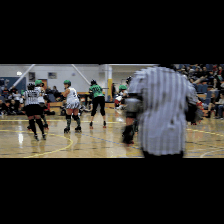

In [25]:
to_gif(sample_video)

In addition to examining this video, you can also display the UCF-101 data. To do this, run the following code:

In [ ]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

Next, define the `FrameGenerator` class in order to create an iterable object that can feed data into the TensorFlow data pipeline. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [26]:
class FrameGenerator:
  def __init__(self, path, n_frames):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        classes: List of labels for classification.
    """
    self.path = path
    self.n_frames = n_frames
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    random.shuffle(pairs)

    shuffled_video_paths, shuffled_classes = zip(*pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

Test out the `FrameGenerator` object before wrapping it as a TensorFlow Dataset object.

In [27]:
fg = FrameGenerator(subset_paths['train'], 10)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 3


Finally, create a TensorFlow data input pipeline. This pipeline that you create from the generator object allows you to feed in data to your deep learning model. In this video pipeline, each element is a single set of frames and its associated label.

In [28]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10),
                                          output_signature = output_signature)

In [29]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [30]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


## Configure the dataset for performance

Use buffered prefetching such that you can yield data from the disk without having I/O become blocking. Two important functions to use while loading data are:

* `Dataset.cache`: keeps the sets of frames in memory after they're loaded off the disk during the first epoch. This function ensures that the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* `Dataset.prefetch`: overlaps data preprocessing and model execution while training.
Refer to [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance) for details.

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

To prepare the data to be fed into the model, use batching as shown below. Notice that when working with video data, such as AVI files, the data should be shaped as a five dimensional object. These dimensions are as follows: `[batch_size, number_of_frames, height, width, channels]`. In comparison, an image would have four dimensions: `[batch_size, height, width, channels]`. The image below is an illustration of how the shape of video data is represented.

![Video data shape](https://www.tensorflow.org/images/tutorials/video/video_data_shape.png)



In [32]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)


Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


## Next steps

Now that you have created a TensorFlow `Dataset` of video frames with their labels, you can use it with a deep learning model. The following classification model that uses a pre-trained [EfficientNet](https://arxiv.org/abs/1905.11946){:.external} trains to high accuracy in a few minutes:

In [33]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds, 
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

    8192/16705208 [..............................] - ETA: 0s

 7495680/16705208 [============>.................] - ETA: 0s

16705208/16705208 [==============================] - 0s 0us/step


Epoch 1/10


      1/Unknown - 16s 16s/step - loss: 2.3838 - accuracy: 0.0000e+00

      3/Unknown - 16s 34ms/step - loss: 2.4767 - accuracy: 0.0000e+00

      5/Unknown - 16s 34ms/step - loss: 2.2688 - accuracy: 0.0000e+00

      7/Unknown - 16s 34ms/step - loss: 2.2852 - accuracy: 0.0000e+00

      9/Unknown - 16s 33ms/step - loss: 2.3330 - accuracy: 0.0556    

     11/Unknown - 16s 33ms/step - loss: 2.3929 - accuracy: 0.0455

     13/Unknown - 17s 32ms/step - loss: 2.5762 - accuracy: 0.0385

     15/Unknown - 17s 32ms/step - loss: 2.5237 - accuracy: 0.0667

     17/Unknown - 17s 32ms/step - loss: 2.5272 - accuracy: 0.0588

     19/Unknown - 17s 31ms/step - loss: 2.5206 - accuracy: 0.0789

     21/Unknown - 17s 31ms/step - loss: 2.5239 - accuracy: 0.0714

     23/Unknown - 17s 31ms/step - loss: 2.5203 - accuracy: 0.0870

     25/Unknown - 17s 31ms/step - loss: 2.4900 - accuracy: 0.0800

     27/Unknown - 17s 31ms/step - loss: 2.4990 - accuracy: 0.0741

     29/Unknown - 17s 31ms/step - loss: 2.4889 - accuracy: 0.0690

     31/Unknown - 17s 31ms/step - loss: 2.5147 - accuracy: 0.0645

     33/Unknown - 17s 31ms/step - loss: 2.4918 - accuracy: 0.0606

     35/Unknown - 17s 30ms/step - loss: 2.5215 - accuracy: 0.0571

     37/Unknown - 17s 30ms/step - loss: 2.5286 - accuracy: 0.0541

     39/Unknown - 17s 30ms/step - loss: 2.5384 - accuracy: 0.0513

     41/Unknown - 17s 30ms/step - loss: 2.5256 - accuracy: 0.0488

     43/Unknown - 17s 30ms/step - loss: 2.5100 - accuracy: 0.0465

     45/Unknown - 17s 30ms/step - loss: 2.5073 - accuracy: 0.0444

     47/Unknown - 18s 30ms/step - loss: 2.5019 - accuracy: 0.0532

     49/Unknown - 18s 30ms/step - loss: 2.5018 - accuracy: 0.0612

     51/Unknown - 18s 30ms/step - loss: 2.5099 - accuracy: 0.0588

     53/Unknown - 18s 30ms/step - loss: 2.4958 - accuracy: 0.0660

     55/Unknown - 18s 30ms/step - loss: 2.4954 - accuracy: 0.0636

     57/Unknown - 18s 30ms/step - loss: 2.4914 - accuracy: 0.0614

     59/Unknown - 18s 30ms/step - loss: 2.4815 - accuracy: 0.0678

     61/Unknown - 18s 30ms/step - loss: 2.4797 - accuracy: 0.0656

     63/Unknown - 18s 30ms/step - loss: 2.4742 - accuracy: 0.0635

     65/Unknown - 18s 30ms/step - loss: 2.4761 - accuracy: 0.0692

     67/Unknown - 18s 30ms/step - loss: 2.4717 - accuracy: 0.0746

     69/Unknown - 18s 30ms/step - loss: 2.4763 - accuracy: 0.0797

     71/Unknown - 18s 30ms/step - loss: 2.4803 - accuracy: 0.0775

     73/Unknown - 18s 30ms/step - loss: 2.4794 - accuracy: 0.0822

     75/Unknown - 18s 30ms/step - loss: 2.4794 - accuracy: 0.0800

     77/Unknown - 18s 30ms/step - loss: 2.4813 - accuracy: 0.0779

     79/Unknown - 18s 30ms/step - loss: 2.4724 - accuracy: 0.0823

     81/Unknown - 19s 30ms/step - loss: 2.4694 - accuracy: 0.0802

     83/Unknown - 19s 30ms/step - loss: 2.4667 - accuracy: 0.0783

     85/Unknown - 19s 30ms/step - loss: 2.4758 - accuracy: 0.0765

     87/Unknown - 19s 30ms/step - loss: 2.4675 - accuracy: 0.0805

     89/Unknown - 19s 30ms/step - loss: 2.4711 - accuracy: 0.0787

     91/Unknown - 19s 30ms/step - loss: 2.4671 - accuracy: 0.0824

     93/Unknown - 19s 30ms/step - loss: 2.4677 - accuracy: 0.0806

     95/Unknown - 19s 30ms/step - loss: 2.4697 - accuracy: 0.0842

     97/Unknown - 19s 30ms/step - loss: 2.4630 - accuracy: 0.0876

     99/Unknown - 19s 30ms/step - loss: 2.4697 - accuracy: 0.0859

    101/Unknown - 19s 30ms/step - loss: 2.4709 - accuracy: 0.0842

    103/Unknown - 19s 30ms/step - loss: 2.4682 - accuracy: 0.0825

    105/Unknown - 19s 30ms/step - loss: 2.4712 - accuracy: 0.0810

    107/Unknown - 19s 30ms/step - loss: 2.4725 - accuracy: 0.0794

    109/Unknown - 19s 30ms/step - loss: 2.4727 - accuracy: 0.0780

    111/Unknown - 19s 30ms/step - loss: 2.4676 - accuracy: 0.0766

    113/Unknown - 20s 30ms/step - loss: 2.4656 - accuracy: 0.0796

    115/Unknown - 20s 30ms/step - loss: 2.4621 - accuracy: 0.0826

    117/Unknown - 20s 30ms/step - loss: 2.4620 - accuracy: 0.0812

    119/Unknown - 20s 30ms/step - loss: 2.4591 - accuracy: 0.0840

    121/Unknown - 20s 30ms/step - loss: 2.4603 - accuracy: 0.0826

    123/Unknown - 20s 30ms/step - loss: 2.4591 - accuracy: 0.0813

    125/Unknown - 20s 30ms/step - loss: 2.4607 - accuracy: 0.0800

    127/Unknown - 20s 30ms/step - loss: 2.4603 - accuracy: 0.0787

    129/Unknown - 20s 30ms/step - loss: 2.4547 - accuracy: 0.0775

    131/Unknown - 20s 30ms/step - loss: 2.4583 - accuracy: 0.0763

    133/Unknown - 20s 30ms/step - loss: 2.4586 - accuracy: 0.0752

    135/Unknown - 20s 30ms/step - loss: 2.4506 - accuracy: 0.0778

    137/Unknown - 20s 30ms/step - loss: 2.4556 - accuracy: 0.0766

    139/Unknown - 20s 30ms/step - loss: 2.4510 - accuracy: 0.0827

    141/Unknown - 20s 30ms/step - loss: 2.4547 - accuracy: 0.0816

    143/Unknown - 20s 30ms/step - loss: 2.4606 - accuracy: 0.0804

    145/Unknown - 20s 30ms/step - loss: 2.4579 - accuracy: 0.0793

    147/Unknown - 21s 30ms/step - loss: 2.4559 - accuracy: 0.0782

    149/Unknown - 21s 30ms/step - loss: 2.4569 - accuracy: 0.0772

150/150 [==============================] - 25s 60ms/step - loss: 2.4562 - accuracy: 0.0767 - val_loss: 2.4089 - val_accuracy: 0.1000


Epoch 2/10


  1/150 [..............................] - ETA: 4s - loss: 2.7793 - accuracy: 0.0000e+00

  3/150 [..............................] - ETA: 4s - loss: 2.7086 - accuracy: 0.0000e+00

  5/150 [>.............................] - ETA: 4s - loss: 2.5271 - accuracy: 0.0000e+00

  7/150 [>.............................] - ETA: 4s - loss: 2.4948 - accuracy: 0.0714    

  9/150 [>.............................] - ETA: 4s - loss: 2.5069 - accuracy: 0.0556

 11/150 [=>............................] - ETA: 4s - loss: 2.4772 - accuracy: 0.0455

 13/150 [=>............................] - ETA: 4s - loss: 2.4576 - accuracy: 0.0385

 15/150 [==>...........................] - ETA: 4s - loss: 2.4261 - accuracy: 0.0333

 17/150 [==>...........................] - ETA: 3s - loss: 2.4034 - accuracy: 0.0294

 19/150 [==>...........................] - ETA: 3s - loss: 2.3923 - accuracy: 0.0526

 21/150 [===>..........................] - ETA: 3s - loss: 2.4278 - accuracy: 0.0476

 23/150 [===>..........................] - ETA: 3s - loss: 2.4836 - accuracy: 0.0435

 25/150 [====>.........................] - ETA: 3s - loss: 2.5066 - accuracy: 0.0400

 27/150 [====>.........................] - ETA: 3s - loss: 2.4794 - accuracy: 0.0370

 29/150 [====>.........................] - ETA: 3s - loss: 2.4713 - accuracy: 0.0345

 31/150 [=====>........................] - ETA: 3s - loss: 2.4625 - accuracy: 0.0323

 33/150 [=====>........................] - ETA: 3s - loss: 2.4824 - accuracy: 0.0303

 35/150 [======>.......................] - ETA: 3s - loss: 2.4855 - accuracy: 0.0429

 37/150 [======>.......................] - ETA: 3s - loss: 2.4718 - accuracy: 0.0541

 39/150 [======>.......................] - ETA: 3s - loss: 2.4690 - accuracy: 0.0641

 41/150 [=======>......................] - ETA: 3s - loss: 2.4599 - accuracy: 0.0610

 43/150 [=======>......................] - ETA: 3s - loss: 2.4421 - accuracy: 0.0581

 45/150 [========>.....................] - ETA: 3s - loss: 2.4276 - accuracy: 0.0667

 47/150 [========>.....................] - ETA: 3s - loss: 2.4186 - accuracy: 0.0638

 49/150 [========>.....................] - ETA: 2s - loss: 2.4262 - accuracy: 0.0612

 51/150 [=========>....................] - ETA: 2s - loss: 2.4198 - accuracy: 0.0588

 53/150 [=========>....................] - ETA: 2s - loss: 2.4349 - accuracy: 0.0566

 55/150 [==========>...................] - ETA: 2s - loss: 2.4219 - accuracy: 0.0636

 57/150 [==========>...................] - ETA: 2s - loss: 2.4506 - accuracy: 0.0614

 59/150 [==========>...................] - ETA: 2s - loss: 2.4413 - accuracy: 0.0678

 61/150 [===========>..................] - ETA: 2s - loss: 2.4356 - accuracy: 0.0656

 63/150 [===========>..................] - ETA: 2s - loss: 2.4388 - accuracy: 0.0714

 65/150 [============>.................] - ETA: 2s - loss: 2.4472 - accuracy: 0.0769

 67/150 [============>.................] - ETA: 2s - loss: 2.4529 - accuracy: 0.0746

 69/150 [============>.................] - ETA: 2s - loss: 2.4575 - accuracy: 0.0725

 71/150 [=============>................] - ETA: 2s - loss: 2.4541 - accuracy: 0.0704

 73/150 [=============>................] - ETA: 2s - loss: 2.4589 - accuracy: 0.0753

 75/150 [==============>...............] - ETA: 2s - loss: 2.4578 - accuracy: 0.0733

 77/150 [==============>...............] - ETA: 2s - loss: 2.4476 - accuracy: 0.0779

 79/150 [==============>...............] - ETA: 2s - loss: 2.4428 - accuracy: 0.0823

 81/150 [===============>..............] - ETA: 2s - loss: 2.4441 - accuracy: 0.0802

 83/150 [===============>..............] - ETA: 1s - loss: 2.4418 - accuracy: 0.0843

 85/150 [================>.............] - ETA: 1s - loss: 2.4389 - accuracy: 0.0824

 87/150 [================>.............] - ETA: 1s - loss: 2.4385 - accuracy: 0.0805

 89/150 [================>.............] - ETA: 1s - loss: 2.4310 - accuracy: 0.0843

 91/150 [=================>............] - ETA: 1s - loss: 2.4233 - accuracy: 0.0879

 93/150 [=================>............] - ETA: 1s - loss: 2.4272 - accuracy: 0.0860

 95/150 [==================>...........] - ETA: 1s - loss: 2.4274 - accuracy: 0.0895

 97/150 [==================>...........] - ETA: 1s - loss: 2.4326 - accuracy: 0.0876

 99/150 [==================>...........] - ETA: 1s - loss: 2.4269 - accuracy: 0.0909

101/150 [===================>..........] - ETA: 1s - loss: 2.4275 - accuracy: 0.0891

103/150 [===================>..........] - ETA: 1s - loss: 2.4334 - accuracy: 0.0874

105/150 [====================>.........] - ETA: 1s - loss: 2.4368 - accuracy: 0.0857

107/150 [====================>.........] - ETA: 1s - loss: 2.4348 - accuracy: 0.0841

109/150 [====================>.........] - ETA: 1s - loss: 2.4268 - accuracy: 0.0917

111/150 [=====================>........] - ETA: 1s - loss: 2.4265 - accuracy: 0.0946

113/150 [=====================>........] - ETA: 1s - loss: 2.4315 - accuracy: 0.0929

115/150 [======================>.......] - ETA: 1s - loss: 2.4333 - accuracy: 0.0913

117/150 [======================>.......] - ETA: 0s - loss: 2.4328 - accuracy: 0.0897

119/150 [======================>.......] - ETA: 0s - loss: 2.4320 - accuracy: 0.0924

121/150 [=======================>......] - ETA: 0s - loss: 2.4276 - accuracy: 0.0950

123/150 [=======================>......] - ETA: 0s - loss: 2.4207 - accuracy: 0.0935

125/150 [========================>.....] - ETA: 0s - loss: 2.4163 - accuracy: 0.0960

127/150 [========================>.....] - ETA: 0s - loss: 2.4144 - accuracy: 0.0945

129/150 [========================>.....] - ETA: 0s - loss: 2.4170 - accuracy: 0.0969

131/150 [=========================>....] - ETA: 0s - loss: 2.4263 - accuracy: 0.0954

133/150 [=========================>....] - ETA: 0s - loss: 2.4290 - accuracy: 0.0977

135/150 [==========================>...] - ETA: 0s - loss: 2.4241 - accuracy: 0.1000

137/150 [==========================>...] - ETA: 0s - loss: 2.4199 - accuracy: 0.1022

139/150 [==========================>...] - ETA: 0s - loss: 2.4172 - accuracy: 0.1007

141/150 [===========================>..] - ETA: 0s - loss: 2.4159 - accuracy: 0.0993

143/150 [===========================>..] - ETA: 0s - loss: 2.4134 - accuracy: 0.0979

145/150 [============================>.] - ETA: 0s - loss: 2.4149 - accuracy: 0.0966

147/150 [============================>.] - ETA: 0s - loss: 2.4152 - accuracy: 0.0986

149/150 [============================>.] - ETA: 0s - loss: 2.4257 - accuracy: 0.0973

150/150 [==============================] - 6s 39ms/step - loss: 2.4257 - accuracy: 0.0967 - val_loss: 2.4790 - val_accuracy: 0.1000


Epoch 3/10


  1/150 [..............................] - ETA: 4s - loss: 1.8705 - accuracy: 0.0000e+00

  3/150 [..............................] - ETA: 4s - loss: 2.0013 - accuracy: 0.0000e+00

  5/150 [>.............................] - ETA: 4s - loss: 2.1498 - accuracy: 0.1000    

  7/150 [>.............................] - ETA: 4s - loss: 2.2369 - accuracy: 0.1429

  9/150 [>.............................] - ETA: 4s - loss: 2.2101 - accuracy: 0.1111

 11/150 [=>............................] - ETA: 4s - loss: 2.2362 - accuracy: 0.1364

 13/150 [=>............................] - ETA: 4s - loss: 2.3038 - accuracy: 0.1154

 15/150 [==>...........................] - ETA: 4s - loss: 2.2655 - accuracy: 0.1333

 17/150 [==>...........................] - ETA: 3s - loss: 2.2774 - accuracy: 0.1471

 19/150 [==>...........................] - ETA: 3s - loss: 2.2888 - accuracy: 0.1316

 21/150 [===>..........................] - ETA: 3s - loss: 2.2935 - accuracy: 0.1429

 23/150 [===>..........................] - ETA: 3s - loss: 2.3119 - accuracy: 0.1522

 25/150 [====>.........................] - ETA: 3s - loss: 2.3317 - accuracy: 0.1600

 27/150 [====>.........................] - ETA: 3s - loss: 2.3310 - accuracy: 0.1481

 29/150 [====>.........................] - ETA: 3s - loss: 2.3333 - accuracy: 0.1552

 31/150 [=====>........................] - ETA: 3s - loss: 2.3496 - accuracy: 0.1613

 33/150 [=====>........................] - ETA: 3s - loss: 2.3498 - accuracy: 0.1667

 35/150 [======>.......................] - ETA: 3s - loss: 2.3588 - accuracy: 0.1571

 37/150 [======>.......................] - ETA: 3s - loss: 2.3540 - accuracy: 0.1622

 39/150 [======>.......................] - ETA: 3s - loss: 2.3740 - accuracy: 0.1538

 41/150 [=======>......................] - ETA: 3s - loss: 2.3664 - accuracy: 0.1463

 43/150 [=======>......................] - ETA: 3s - loss: 2.3510 - accuracy: 0.1512

 45/150 [========>.....................] - ETA: 3s - loss: 2.3310 - accuracy: 0.1556

 47/150 [========>.....................] - ETA: 3s - loss: 2.3480 - accuracy: 0.1489

 49/150 [========>.....................] - ETA: 2s - loss: 2.3504 - accuracy: 0.1531

 51/150 [=========>....................] - ETA: 2s - loss: 2.3653 - accuracy: 0.1471

 53/150 [=========>....................] - ETA: 2s - loss: 2.3788 - accuracy: 0.1415

 55/150 [==========>...................] - ETA: 2s - loss: 2.3694 - accuracy: 0.1455

 57/150 [==========>...................] - ETA: 2s - loss: 2.3739 - accuracy: 0.1404

 59/150 [==========>...................] - ETA: 2s - loss: 2.3892 - accuracy: 0.1356

 61/150 [===========>..................] - ETA: 2s - loss: 2.3825 - accuracy: 0.1311

 63/150 [===========>..................] - ETA: 2s - loss: 2.3888 - accuracy: 0.1349

 65/150 [============>.................] - ETA: 2s - loss: 2.3950 - accuracy: 0.1385

 67/150 [============>.................] - ETA: 2s - loss: 2.3855 - accuracy: 0.1343

 69/150 [============>.................] - ETA: 2s - loss: 2.3954 - accuracy: 0.1304

 71/150 [=============>................] - ETA: 2s - loss: 2.4105 - accuracy: 0.1268

 73/150 [=============>................] - ETA: 2s - loss: 2.4074 - accuracy: 0.1233

 75/150 [==============>...............] - ETA: 2s - loss: 2.4118 - accuracy: 0.1200

 77/150 [==============>...............] - ETA: 2s - loss: 2.4203 - accuracy: 0.1169

 79/150 [==============>...............] - ETA: 2s - loss: 2.4186 - accuracy: 0.1139

 81/150 [===============>..............] - ETA: 2s - loss: 2.4169 - accuracy: 0.1173

 83/150 [===============>..............] - ETA: 1s - loss: 2.4134 - accuracy: 0.1205

 85/150 [================>.............] - ETA: 1s - loss: 2.4121 - accuracy: 0.1235

 87/150 [================>.............] - ETA: 1s - loss: 2.4090 - accuracy: 0.1207

 89/150 [================>.............] - ETA: 1s - loss: 2.4098 - accuracy: 0.1180

 91/150 [=================>............] - ETA: 1s - loss: 2.4060 - accuracy: 0.1209

 93/150 [=================>............] - ETA: 1s - loss: 2.4067 - accuracy: 0.1183

 95/150 [==================>...........] - ETA: 1s - loss: 2.4009 - accuracy: 0.1158

 97/150 [==================>...........] - ETA: 1s - loss: 2.3932 - accuracy: 0.1289

 99/150 [==================>...........] - ETA: 1s - loss: 2.4023 - accuracy: 0.1263

101/150 [===================>..........] - ETA: 1s - loss: 2.4011 - accuracy: 0.1287

103/150 [===================>..........] - ETA: 1s - loss: 2.4059 - accuracy: 0.1262

105/150 [====================>.........] - ETA: 1s - loss: 2.4186 - accuracy: 0.1238

107/150 [====================>.........] - ETA: 1s - loss: 2.4131 - accuracy: 0.1262

109/150 [====================>.........] - ETA: 1s - loss: 2.4153 - accuracy: 0.1239

111/150 [=====================>........] - ETA: 1s - loss: 2.4194 - accuracy: 0.1216

113/150 [=====================>........] - ETA: 1s - loss: 2.4202 - accuracy: 0.1195

115/150 [======================>.......] - ETA: 1s - loss: 2.4170 - accuracy: 0.1174

117/150 [======================>.......] - ETA: 0s - loss: 2.4221 - accuracy: 0.1154

119/150 [======================>.......] - ETA: 0s - loss: 2.4205 - accuracy: 0.1134

121/150 [=======================>......] - ETA: 0s - loss: 2.4209 - accuracy: 0.1116

123/150 [=======================>......] - ETA: 0s - loss: 2.4191 - accuracy: 0.1098

125/150 [========================>.....] - ETA: 0s - loss: 2.4226 - accuracy: 0.1120

127/150 [========================>.....] - ETA: 0s - loss: 2.4162 - accuracy: 0.1142

129/150 [========================>.....] - ETA: 0s - loss: 2.4157 - accuracy: 0.1163

131/150 [=========================>....] - ETA: 0s - loss: 2.4086 - accuracy: 0.1145

133/150 [=========================>....] - ETA: 0s - loss: 2.4074 - accuracy: 0.1165

135/150 [==========================>...] - ETA: 0s - loss: 2.4068 - accuracy: 0.1185

137/150 [==========================>...] - ETA: 0s - loss: 2.4057 - accuracy: 0.1204

139/150 [==========================>...] - ETA: 0s - loss: 2.4130 - accuracy: 0.1187

141/150 [===========================>..] - ETA: 0s - loss: 2.4129 - accuracy: 0.1206

143/150 [===========================>..] - ETA: 0s - loss: 2.4123 - accuracy: 0.1189

145/150 [============================>.] - ETA: 0s - loss: 2.4097 - accuracy: 0.1172

147/150 [============================>.] - ETA: 0s - loss: 2.4077 - accuracy: 0.1190

149/150 [============================>.] - ETA: 0s - loss: 2.4081 - accuracy: 0.1174

150/150 [==============================] - 6s 39ms/step - loss: 2.4041 - accuracy: 0.1233 - val_loss: 2.4171 - val_accuracy: 0.1000
